# Stop and Frisk data exploration
<br>
In this notebook, I look at the NYPD stop and frisk data. I'm trying to uncover patterns in police interactions, looking at the impact of race, geographic location and sexism on probability of arrests and frisks. What variables drive the type of interaction we have with the police in NYC? On the technical side, I mess around with some ensemble methods.

If you want to run this notebook yourself, download the nypd data into the same directory as this notebook and run the appendix first to get the list of features for each model.

<b> Sections: </b> <br>
<a href='#dt_imp'> Data Import </a> - get data, look at distributions by race 
<br>
<a href='#frisk_model'> Frisk Model </a> - can I predict if a suspect was frisked only based on immediately observed features
<br>
<a href='#arrest_made'> Arrest Model </a> - can I predict if a suspect was arrested using all info available at that time?
<br>
<a href='#appendix'> Appendix </a> - all my feature selection for each model. These are long lists, and not so fun.

<b> Note on the data: </b> <br>
This data is not perfect. It is self reported, and comes from the police itself. Some of the variables may be misreported to retro-fit a desired explanation for an incident. Ex: in the "reason for frisk" features, policemen may say they saw furtive movements, when in fact it was a gut feeling/another reason that they'd rather not admit to their boss. It is likely that any kind of socially undesired bias is underreported in this dataset.

<a id='dt_imp'></a>

<h3> Data import, basic pre-processing and distributions by race

In [711]:
import pandas as pd
import numpy as np

In [712]:
import warnings ; warnings.simplefilter('ignore')
df_2016=pd.read_csv('2016.csv')
df_2015=pd.read_csv('2015.csv')
df_2014=pd.read_csv('2014.csv')
df_2013=pd.read_csv('2013.csv')

In [713]:
df=pd.concat([df_2016, df_2015, df_2014, df_2013], axis=0, ignore_index=True)

In [621]:
df

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypCM,lineCM,detailCM
0,2016,41,22,2072016,100,A,O,P,1,BURG,...,,41,B,2,,1013353,234000,CM,1,14
1,2016,10,22,2182016,30,1,O,P,8,MISDEMEANOR,...,,10,D,,,983478,212373,CM,1,28
2,2016,66,1,1012016,30,1,I,P,2,FEL,...,,66,F,,,988340,172111,CM,1,9
3,2016,47,18,1012016,40,1,O,H,1,FEL,...,,47,C,,,,,CM,1,20
4,2016,79,1,1012016,50,1,O,P,3,D.W.I.,...,,79,G,4,,998197,187413,CM,1,112
5,2016,73,1,1012016,100,1,O,P,1,FELONY,...,,73,B,2,,1008226,186458,CM,1,20
6,2016,43,6,1012016,130,1,O,P,1,FEL,...,,43,H,,,1017874,241632,CM,1,20
7,2016,67,3,1012016,135,1,O,P,1,FEL,...,,67,C,,,1007676,179158,CM,1,20
8,2016,43,12,1012016,210,1,O,P,1,MISD,...,,43,E,,,1018623,240382,CM,1,20
9,2016,73,2,1012016,210,1,O,P,2,MISD,...,,73,K,11,,1010445,181444,CM,1,9


In [714]:
from Pandas_initial_profiler.profiler import dtype_profiler

In [623]:
dtype_profiler.dtype_profiler(df, check_nan=True, hist=3, top_x=3)

COL  1 OF  112 :  year
BASICS: numpy dtype:  object    | dtype:  true string   | flag:  none      | non null:  272606 

UNIQUE:            #_____________________________ .000 6/272606
DTYPES:
  int              IIIIIIIIIIIIIIIIIIIIIIIIIIII..  
  int-like string                              i.  
  string                                        S  

VALUE COUNTS :
2013 :                            #####################_________ .704 191851/272606  | 
2014 :                            ######________________________ .168 45787/272606  | 
2015 :                            ###___________________________ .083 22563/272606  | 

------------------------------------------------------------------------------------------------------------------------
COL  2 OF  112 :  pct
BASICS: numpy dtype:  object    | dtype:  true string   | flag:  none      | non null:  272606 

UNIQUE:            #_____________________________ .001 155/272606
DTYPES:
  int              IIIIIIIIIIIIIIIIIIIIIIIIIIII..  
  int-l

<b> Before we start, let's do a bit of data pre-processing. </b> <br>
All the numerical columns are stored as objects. Let's convert those, and change all nans or equivalent to 0

In [715]:
#some of these aren't technicall numericals, but there's no leading 0s and they're digits
num_i=['year', 'pct', 'compyear', 'comppct', 'repcmd', 'revcmd', 'age'
           ]
num_f=['weight', 'ht_feet']

In [716]:
#No 0s in any of the numerical columns - I can safely impute nans as 0s for now
for col in num_i:
    print(sum(df[col][df[col]==0]))
for col in num_f:
    print(sum(df[col][df[col]==0]))

0
0
0
0
0
0
0
0
0


In [717]:
for col in num_f:
    df.loc[df[col].isin(['', ' ']), col]=0
    df[col]=df[col].astype(float)
for col in num_i:
    try:
        df.loc[df[col].isin(['', ' ', '**']), col]=0
        df[col]=df[col].astype(int)
    except ValueError:
        print(col, df[col].iloc[1:10])

Basic feature engineering: Changing time of stop to hour of stop

In [718]:
#This is a very ugly function which I wrote quickly. Definitely a way to automate this.
def timestop_to_tofday(time):
    time_str=str(time)
    
    if(len(time_str)==4):
        h=int(time_str[0:2])
    elif(len(time_str)==3):
        h=int(time_str[0])
    elif(time_str in ['', ' ']):
        return 'N'
    else:
        h=0
    
    #6 buckets for time, with 5 being the latest and 0 being the lowest
    
    return int(h/6)
        
df['timestop']=df['timestop'].apply(timestop_to_tofday)

In [628]:
dtype_profiler.dtype_profiler(df, top_x=3, hist=3, check_nan=True, vc_nonan=True)

COL  1 OF  112 :  year
BASICS: numpy dtype:  int32     | dtype:  int-like      | flag:  none      | non null:  272606 

UNIQUE:            #_____________________________ .000 5/272606
VALUE COUNTS :
2013 :                            #####################_________ .704 191851/272606  | 0.7038
2014 :                            ######________________________ .168 45787/272606  | 0.168
2015 :                            ###___________________________ .083 22563/272606  | 0.0828

------------------------------------------------------------------------------------------------------------------------
COL  2 OF  112 :  pct
BASICS: numpy dtype:  int32     | dtype:  int-like      | flag:  none      | non null:  272606 

UNIQUE:            #_____________________________ .000 78/272606
VALUE COUNTS :
73 :                              ##____________________________ .034 9338/272606  | 0.0343
75 :                              #_____________________________ .032 8718/272606  | 0.032
101 :             

KeyboardInterrupt: 

In [719]:
#Dropping noninteresting variables
df.drop(['ser_num', 'state'], inplace=True, axis=1)

In [720]:
df['arstmade'].value_counts()

N    243653
Y     28952
          1
Name: arstmade, dtype: int64

Format conversion for the height variable

In [721]:
def height_to_float(h):
    if h in ['', ' ']:
        return np.NaN
    else:
        return float(h)
    
df['ht_inch']=df['ht_inch'].apply(height_to_float)

In [722]:
df['ht_inch'].fillna(value=df['ht_inch'].median(), inplace=True)

Binning sparse categories in crime susp to get a manageable feature

In [723]:
def crim_susp(var):
    if(var in ['FEL', 'FELONY']):
        return 'FEL'
    elif(var in ['ROBBERY', 'MISD', 'CPW', 'BURGLARY', 'GLA', 'MISDEMEANOR']):
        return var
    else:
        return 'OTHER'
df['crimsusp']=df['crimsusp'].apply(crim_susp)

In [724]:
df['crimsusp'].value_counts()

FEL            98469
OTHER          62987
MISD           40541
CPW            29556
ROBBERY        17680
BURGLARY       10316
GLA             8073
MISDEMEANOR     4984
Name: crimsusp, dtype: int64

Histograms: interacting race and features to see if there are differences in distributions

In [725]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [747]:
#Function that creates a graph breaking down a variable by race. Pass a LIST in the cols argument.
# Yes, I know these shouldn't be line plots - it's just to get a quick visualization.
def breakdown_by_race(cols, max_=5):
    n_plots=len(cols)
    l=len(df)
    
    #set up 3 races datasets
    black=df[df['race']=='B']
    hisp=df[df['race']=='Q']
    white=df[df['race']=='W']    
    
    #set up the subplots
    fig, axs = plt.subplots(n_plots, 1, figsize=(10,5*n_plots))
    fig.tight_layout(h_pad=10.0)

    #main loop graphing
    for ax, i in zip(axs, range(n_plots)):
        column=cols[i]
        
        #x labels
        x=white[column].unique()
        
        #value counts for 3 main races
        y_w=white[column].value_counts(normalize=True).reset_index()
        y_b=black[column].value_counts(normalize=True).reset_index()
        y_q=hisp[column].value_counts(normalize=True).reset_index()
        
        #create x_ticks,sort
        sorter=y_b.iloc[:,0]
        sorterIndex = dict(zip(sorter,range(len(sorter))))
        
        for frame in [y_w, y_b, y_q]:
            frame['rank'] = frame.iloc[:,0].map(sorterIndex)
            frame.sort(['rank'], ascending=True, inplace = True)
            frame.drop(['rank', 'index'], 1, inplace = True)
            
        if(len(y_w)>max_):
            y_w=y_w.iloc[0:max_]
            y_b=y_b.iloc[0:max_]
            y_q=y_q.iloc[0:max_]
        
        #plotting
        ax.plot(np.array(y_w), alpha=0.5, color='b', label='white')
        ax.plot(np.array(y_b), alpha=0.5, color='g', label='black')
        ax.plot(np.array(y_q), alpha=0.5, color='r', label='hisp')
        ax.legend(prop={'size':20})

        #mapping xtick onto graph
        ax.set_xticks(range(len(y_w)))
        ax.set_xticklabels(sorter, rotation='vertical', fontsize=10)
        ax.set_title(column)

In [85]:
print("[")
for x in sorted(df.columns):
    print("\""+x+"\""+",")
print("]")

[
"ac_assoc",
"ac_cgdir",
"ac_evasv",
"ac_incid",
"ac_inves",
"ac_other",
"ac_proxm",
"ac_rept",
"ac_stsnd",
"ac_time",
"addrnum",
"addrpct",
"addrtyp",
"adtlrept",
"age",
"aptnum",
"arstmade",
"arstoffn",
"asltweap",
"beat",
"build",
"city",
"comppct",
"compyear",
"contrabn",
"crimsusp",
"crossst",
"cs_bulge",
"cs_casng",
"cs_cloth",
"cs_descr",
"cs_drgtr",
"cs_furtv",
"cs_lkout",
"cs_objcs",
"cs_other",
"cs_vcrim",
"datestop",
"detailCM",
"dettypCM",
"dob",
"explnstp",
"eyecolor",
"forceuse",
"frisked",
"haircolr",
"ht_feet",
"ht_inch",
"inout",
"knifcuti",
"lineCM",
"machgun",
"officrid",
"offshld",
"offunif",
"offverb",
"othfeatr",
"othpers",
"othrweap",
"pct",
"perobs",
"perstop",
"pf_baton",
"pf_drwep",
"pf_grnd",
"pf_hands",
"pf_hcuff",
"pf_other",
"pf_pepsp",
"pf_ptwep",
"pf_wall",
"pistol",
"post",
"premname",
"premtype",
"race",
"radio",
"recstat",
"repcmd",
"rescode",
"revcmd",
"rf_attir",
"rf_bulg",
"rf_furt",
"rf_knowl",
"rf_othsw",
"rf_rfcmp",
"rf_vcact",
"rf_vcrim",
"rf_

Click on the cells below to see a breakdown of each batch of the variables. To see the variables in each batch, head over to the appendix

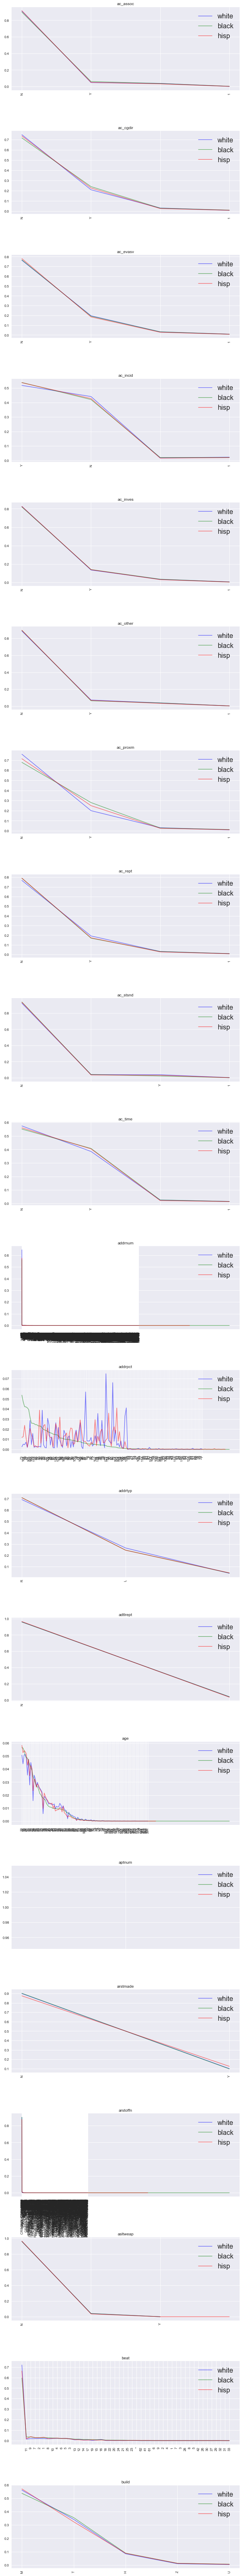

In [638]:
breakdown_by_race(batch_1)

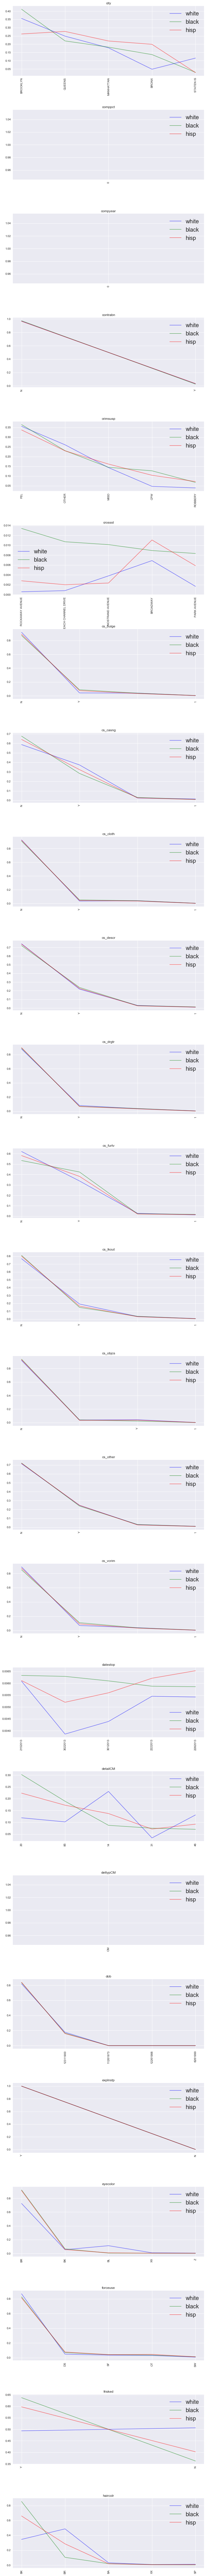

In [664]:
breakdown_by_race(batch_2)

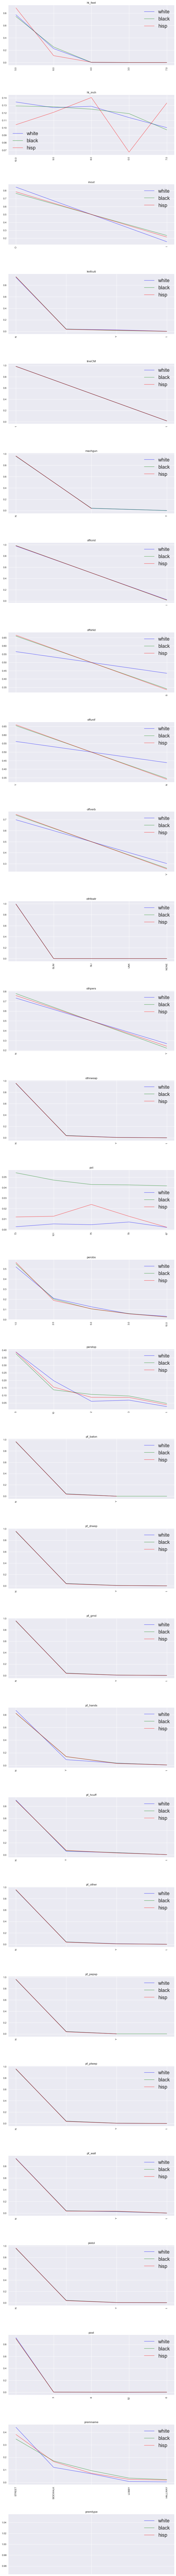

In [665]:
breakdown_by_race(batch_3)

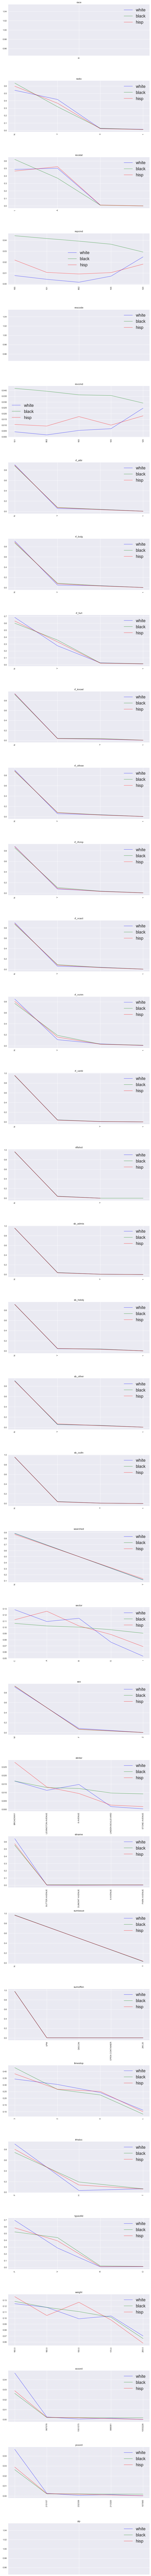

In [666]:
breakdown_by_race(batch_4)

In [112]:
for x in sorted(df.columns):
    print(x)

ac_assoc
ac_cgdir
ac_evasv
ac_incid
ac_inves
ac_other
ac_proxm
ac_rept
ac_stsnd
ac_time
addrnum
addrpct
addrtyp
adtlrept
age
aptnum
arstmade
arstoffn
asltweap
beat
build
city
comppct
compyear
contrabn
crimsusp
crossst
cs_bulge
cs_casng
cs_cloth
cs_descr
cs_drgtr
cs_furtv
cs_lkout
cs_objcs
cs_other
cs_vcrim
datestop
detailCM
dettypCM
dob
explnstp
eyecolor
forceuse
frisked
haircolr
ht_feet
ht_inch
inout
knifcuti
lineCM
machgun
officrid
offshld
offunif
offverb
othfeatr
othpers
othrweap
pct
perobs
perstop
pf_baton
pf_drwep
pf_grnd
pf_hands
pf_hcuff
pf_other
pf_pepsp
pf_ptwep
pf_wall
pistol
post
premname
premtype
race
radio
recstat
repcmd
rescode
revcmd
rf_attir
rf_bulg
rf_furt
rf_knowl
rf_othsw
rf_rfcmp
rf_vcact
rf_vcrim
rf_verbl
riflshot
sb_admis
sb_hdobj
sb_other
sb_outln
searched
sector
sex
stinter
stname
sumissue
sumoffen
timestop
trhsloc
typeofid
weight
xcoord
ycoord
zip


In [175]:
#all the variables that seem to have significant racial differences

racial_dif=['ac_incid', 'ac_proxm', 'ac_rept', 'build', 'city', 'cs_casng', 'cs_descr',
           'cs_furtv', 'cs_lkout', 'cs_other', 'forceuse', 'frisked', 'ht_feet', 'offshld',
           'offunif', 'othpers', 'pf_hands', 'pf_hcuff', 'pf_other', 'radio', 'rf_furt', 'rf_othsw',
           'rf_vcrim', 'typeofid', 'race']

Surprising find: 1/3 suspects that are arrested are not searched, but given you are searched you have just over a 1/2 chance of getting arrested. <br>
As expected, suspects are frisked more than they are searched, and searched more than they are arrested.

In [726]:
srched=df[df['searched']=='Y']
srched['arstmade'].value_counts()

Y    17488
N    15326
Name: arstmade, dtype: int64

In [727]:
df['arstmade'].value_counts()

N    243653
Y     28952
          1
Name: arstmade, dtype: int64

In [728]:
df['frisked'].value_counts()

Y    165180
N    107425
          1
Name: frisked, dtype: int64

<a id='frisk_model'></a>

<h3> Frisking model </h3> <br>
Model 1: Can I predict if a suspect was frisked, using only the features the cop would know about before frisking suspect? I use a random forest and a logistic regression

In [729]:
#This function takes a list of features, encodes them, does the same with the target variable and returns a test/train split
from sklearn import model_selection

def build_dataset(df, target, feats, split=0.3):
    X=df[feats]
    Y=df[target]
    X_enc=pd.get_dummies(X, drop_first=True).iloc[:-1]
    Y_enc=pd.DataFrame(Y).iloc[:-1]
    Y_enc.loc[:,'targ']=0
    Y_enc['targ'].loc[Y_enc[target]=='Y']=1
    Y_enc.drop(target, inplace=True, axis=1)
    return sklearn.model_selection.train_test_split(X_enc, np.array(Y_enc), test_size=split)

In [730]:
X_train, X_test, Y_train, Y_test = build_dataset(df, 'frisked', immediately_apparent)

In [731]:
from sklearn.ensemble import RandomForestClassifier

In [735]:
rf=RandomForestClassifier(n_estimators=100)
rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Model validation: confusion matrix, relative feature importances, ROC curve

In [736]:
import sklearn.metrics
predicted=rf.predict(X_test)
expected=Y_test
print(sklearn.metrics.confusion_matrix(expected, predicted))

[[19604 12565]
 [ 9382 40231]]


In [739]:
print(X_enc.shape, X_train.shape)

(12404, 151) (190823, 99)


In [740]:
for x,y in zip(X_train.columns, rf.feature_importances_):
    print(x, y)

age 0.144848772208
ht_inch 0.104603318373
ac_assoc_1 0.000439309368075
ac_assoc_N 0.00535578085849
ac_assoc_Y 0.00528701076348
ac_cgdir_1 0.000797975875038
ac_cgdir_N 0.0108576777254
ac_cgdir_Y 0.010610885446
ac_evasv_1 0.00075217795242
ac_evasv_N 0.00902786984219
ac_evasv_Y 0.00803354670192
ac_incid_1 0.00102922759011
ac_incid_N 0.0139895550016
ac_incid_Y 0.0140760390111
ac_inves_1 0.000710280346684
ac_inves_N 0.0108282842705
ac_inves_Y 0.0107446187242
ac_other_1 0.000468253759983
ac_other_N 0.0070485852817
ac_other_Y 0.0069225057953
ac_proxm_1 0.000998929641655
ac_proxm_N 0.0115747583711
ac_proxm_Y 0.0110138429828
ac_rept_1 0.000730344451284
ac_rept_N 0.00869999857866
ac_rept_Y 0.00827475386413
ac_stsnd_1 0.000256957847673
ac_stsnd_N 0.00357255645855
ac_stsnd_Y 0.00339656854252
ac_time_1 0.000965263473782
ac_time_N 0.0143611861149
ac_time_Y 0.0141752157036
build_H 0.0110198715667
build_M 0.0199504326012
build_T 0.0187351098833
build_U 0.00147728746966
build_Z 0.00301456687613
city_BR

In [741]:
z=rf.predict_proba(X_test)
predict_prob=[x[1] for x in z]

In [742]:
tupl=sklearn.metrics.roc_curve(expected, predict_prob)
lis=[list(x) for x in tupl]

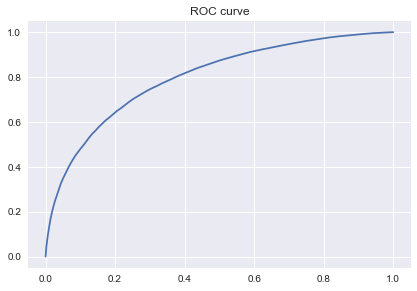

In [743]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax=plt.subplots(1, 1)
fig.tight_layout(h_pad=10.0)
ax.plot(lis[0], lis[1])
ax.set_title('ROC curve')

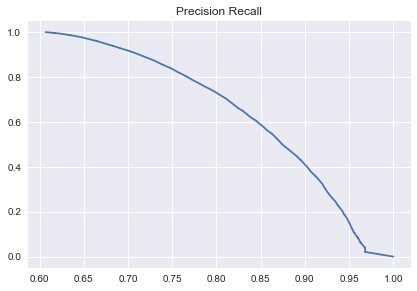

In [744]:
x_rf,y_rf,z_rf=sklearn.metrics.precision_recall_curve(expected, predict_prob)
fig,ax=plt.subplots(1, 1)
fig.tight_layout(h_pad=10.0)
ax.plot(x_rf, y_rf)
ax.set_title('Precision Recall')

Logistic regression

In [601]:
from sklearn.linear_model import LogisticRegression

In [602]:
lr=LogisticRegression(C=0.01)
lr.fit(X_train, Y_train)

C:\Users\Baptiste\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [603]:
predicted=lr.predict(X_train)
expected=Y_train
print(sklearn.metrics.confusion_matrix(expected, predicted))

[[ 802 2328]
 [ 495 5057]]


In [604]:
predicted=lr.predict(X_test)
expected=Y_test
print(sklearn.metrics.confusion_matrix(expected, predicted))

[[ 361  974]
 [ 224 2163]]


In [595]:
for x,y in zip(X_enc.columns, lr.coef_[0]):
    print(x, y)

age -0.00669585305625
compyear 0.0123515154872
ht_inch -0.161943877967
weight 0.285776345795
ac_assoc_N -0.0070631513829
ac_assoc_Y 0.130895619211
ac_cgdir_N -0.130958890972
ac_cgdir_Y 0.254791358799
ac_evasv_N 0.0475937337103
ac_evasv_Y 0.0762387341175
ac_incid_N 0.0558514831417
ac_incid_Y 0.0679809846859
ac_inves_N 0.0937886262797
ac_inves_Y 0.0300438415483
ac_other_N -0.0269172503335
ac_other_Y 0.150749718161
ac_proxm_N -0.00115050269485
ac_proxm_Y 0.124982970523
ac_rept_N -0.0222349423699
ac_rept_Y 0.146067410198
ac_stsnd_N 0.0123194535788
ac_stsnd_Y 0.111513014249
ac_time_N 0.307502943393
ac_time_Y 0.0801453766073
arstmade_N 0.0857020127711
arstmade_Y -0.173782824905
asltweap_N -0.175735040039
asltweap_Y 0.231618099518
build_H 0.0275078496914
build_M 0.0956718984794
build_T 0.0341866326152
build_U -0.265152012476
build_Z -0.715677793739
city_BRONX 0.839510261567
city_BROOKLYN 0.237593683571
city_MANHATTAN -0.113761215743
city_QUEENS 0.0280389325547
city_STATEN IS 0.0957935352728
c

Race is significant. Being black or latino increases your chances of being frisked, while being white decreases your chances. Sex is also very significant (males are more likely), and people are less likely to be frisked very early in the morning. The Bronx is the worst area, Staten Island is the best. You are more likely to be frisked if you have a heavy build, and less likely if you have a muscular build! Being shorter is better to avoid being frisked

In [605]:
#ROC curve - function can still be improved (get better label)
def graph_roc_funcs(expected, models=[], hybrid=False):
    fig,ax=plt.subplots(1, 1, figsize=(8,6))
    fig.tight_layout(h_pad=10.0)
    ax.set_title('ROC curve')
    
    for mod,i in zip(models, range(len(models))):
        label=str(mod)[0:10]
        pr=mod.predict_proba(X_test)
        predict_prob=[x[1] for x in pr]
        tupl=sklearn.metrics.roc_curve(expected, predict_prob)
        lis=[list(x) for x in tupl]
        ax.plot(lis[0], lis[1], label=label)
        
        if hybrid and i==0:
            prs=predict_prob
        else:
            prs=[x+y for x,y in zip(prs,predict_prob)]
    
    if hybrid:
        prs=[x/len(models) for x in prs]
        tupl=sklearn.metrics.roc_curve(expected, prs)
        lis=[list(x) for x in tupl]
        ax.plot(lis[0], lis[1], label='hybrid')
    
    ax.legend()

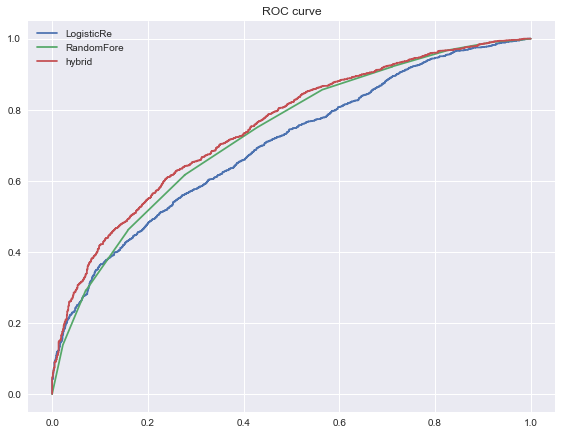

In [606]:
graph_roc_funcs(expected, models=[lr, rf], hybrid=True)

In [703]:
#Precision Recall
def graph_precision_recall(expected=Y_test,sample=X_test, models=[],weights=None, hybrid=False):
    fig,ax=plt.subplots(1, 1, figsize=(8,6))
    fig.tight_layout(h_pad=10.0)
    ax.set_title('Precision-Recall curve')
    
    for mod,i in zip(models, range(len(models))):
        label=str(mod)[0:10]
        pr=mod.predict_proba(sample)
        predict_prob=[x[1] for x in pr]
        tupl=sklearn.metrics.precision_recall_curve(expected, predict_prob)
        lis=[list(x) for x in tupl]
        ax.plot(lis[0], lis[1], label=label)
    
        if hybrid and i==0:
            if not weights:
                prs=predict_prob
            else:
                prs=[x*(weights[0])*len(models) for x in predict_prob]
        else:
            if not weights:
                prs=[x+y for x,y in zip(prs,predict_prob)]
            else:
                prs=[x+(y*weights[i]*len(models)) for x,y in zip(prs,predict_prob)]

                
    if hybrid:
        prs=[x/len(models) for x in prs]
        tupl=sklearn.metrics.precision_recall_curve(expected, prs)
        lis=[list(x) for x in tupl]
        ax.plot(lis[0], lis[1], label='hybrid')
    
    ax.legend()

In [690]:
from sklearn.svm import SVC
svm=SVC(probability=True, C=5)

In [691]:
svm.fit(X_train, Y_train)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

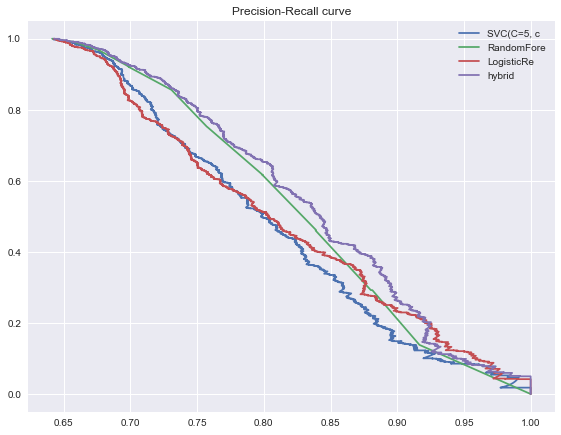

In [706]:
graph_precision_recall(expected, models=[svm, rf, lr],weights=[0.1,0.7,0.2], hybrid=True)

Hybrid validation part 2

In [420]:
prob_logit=[x[1] for x in lr.predict_proba(X_test)]
prob_forest=[x[1] for x in rf.predict_proba(X_test)]
hybrid=[(l+f)/2 for l,f in zip(prob_logit,prob_forest)]
hybrid_s=pd.Series(hybrid)

In [421]:
hybrid_s.loc[hybrid_s>=0.5]=1
hybrid_s.loc[hybrid_s<0.5]=0
hybrid_s

0       1.0
1       0.0
2       1.0
3       1.0
4       1.0
5       1.0
6       1.0
7       1.0
8       1.0
9       1.0
10      1.0
11      1.0
12      1.0
13      1.0
14      1.0
15      1.0
16      1.0
17      1.0
18      1.0
19      1.0
20      0.0
21      1.0
22      1.0
23      0.0
24      1.0
25      1.0
26      1.0
27      1.0
28      0.0
29      1.0
       ... 
3692    1.0
3693    1.0
3694    1.0
3695    1.0
3696    1.0
3697    1.0
3698    1.0
3699    1.0
3700    1.0
3701    1.0
3702    1.0
3703    1.0
3704    1.0
3705    1.0
3706    1.0
3707    1.0
3708    1.0
3709    1.0
3710    1.0
3711    1.0
3712    0.0
3713    1.0
3714    1.0
3715    1.0
3716    1.0
3717    1.0
3718    1.0
3719    1.0
3720    0.0
3721    1.0
dtype: float64

In [423]:
expected=Y_test
print(sklearn.metrics.confusion_matrix(expected, np.array(hybrid_s)))

[[ 548  806]
 [ 331 2037]]


The hybrid model is a little better than both of them, and seems to do best (I asked my boss why, and apparently it's because of entropy - "all happy families are happy in the same way, but all unhappy families are unhappy in a different way"). This is especially true when you have a variance problem, as we do in this case because of our small sample.

<a id='arrest_made'></a>

<h3> Second model: Arrest made </h3> <br>
This is much harder to predict, for a few reasons. Firstly, the classes are more imbalanced, which means greater variance (it's harder to see what causes what when you don't have a lot of arrests). Secondly, policemen have more information available to them, which once again increases the variance of the model (more things could be causing an arrest - it's harder to pin it down). Lastly, it's unclear if the variables are reported the same way when an arrest occurs. The data may be more accurate, or a little distorted because the police know they will face more scrutiny.

<b> Assumption: if a suspect was frisked or searched, it was before the arrest. </b> <br>
We may have to do a little bit of feature engineering and data work before this model. 

In [500]:
#Using the same function as earlier
X_train, X_test, Y_train, Y_test = build_dataset(df, target='arstmade', feats=after_search)

C:\Users\Baptiste\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Random forest

In [708]:
rf=RandomForestClassifier( n_estimators=300)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [709]:
import sklearn.metrics
predicted=rf.predict(X_test)
expected=Y_test
print(sklearn.metrics.confusion_matrix(expected, predicted))

[[ 664  671]
 [ 357 2030]]


In [710]:
for x,y in zip(X_enc.columns, rf.feature_importances_):
    print(x, y)


age 0.136029104859
compyear 0.0980037836598
ht_inch 0.00427019015908
weight 0.00451966474889
ac_assoc_N 0.0084043118557
ac_assoc_Y 0.00838442966276
ac_cgdir_N 0.00682980278862
ac_cgdir_Y 0.00707781356641
ac_evasv_N 0.0110480533623
ac_evasv_Y 0.0107336849056
ac_incid_N 0.00794412123707
ac_incid_Y 0.00786256890019
ac_inves_N 0.0130612324101
ac_inves_Y 0.0133435968963
ac_other_N 0.0121680861018
ac_other_Y 0.0121731982475
ac_proxm_N 0.0157342510651
ac_proxm_Y 0.0159481491362
ac_rept_N 0.00295028167388
ac_rept_Y 0.00306159801171
ac_stsnd_N 0.00836697759138
ac_stsnd_Y 0.00857087392537
ac_time_N 0.0123392009964
ac_time_Y 0.0222560802715
arstmade_N 0.0215396694368
arstmade_Y 0.0030749837959
asltweap_N 0.00459554715494
asltweap_Y 0.0164798440748
build_H 0.0204003549759
build_M 0.0176811586836
build_T 0.018401263573
build_U 0.00988997822
build_Z 0.00986615310237
city_BRONX 0.00920391398855
city_BROOKLYN 0.00941326759245
city_MANHATTAN 0.00959690094584
city_QUEENS 0.00340963207205
city_STATEN IS 

Logistic regression

In [507]:
lr=LogisticRegression()
lr.fit(X_train, Y_train)

C:\Users\Baptiste\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

<a id='appendix'></a>

ROC and precision recall curves

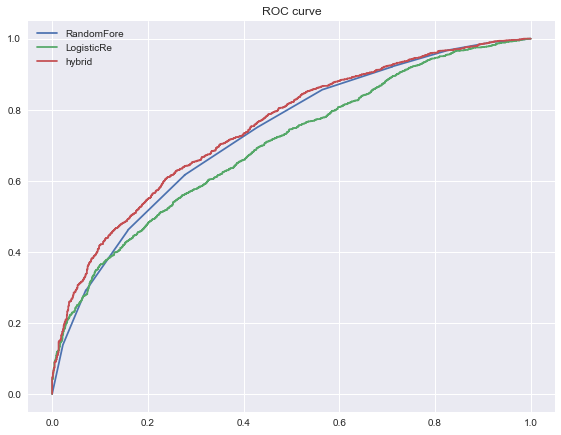

In [609]:
graph_roc_funcs(expected, [rf,lr], hybrid=True)

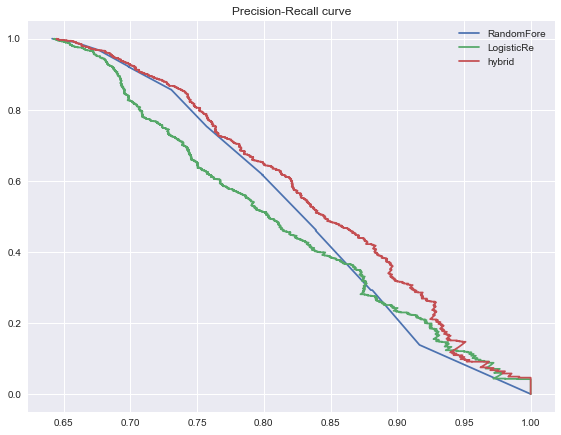

In [611]:
graph_precision_recall(expected, [rf, lr], hybrid=True)

<h3> Appendix </h3> <br>
I stick all my feature selection in here to avoid cluttering the notebook

In [88]:
#batches for histograms
batch_1=[
"ac_assoc",
"ac_cgdir",
"ac_evasv",
"ac_incid",
"ac_inves",
"ac_other",
"ac_proxm",
"ac_rept",
"ac_stsnd",
"ac_time",
"addrnum",
"addrpct",
"addrtyp",
"adtlrept",
"age",
"aptnum",
"arstmade",
"arstoffn",
"asltweap",
"beat",
"build"]

batch_2=[
"city",
"comppct",
"compyear",
"contrabn",
"crimsusp",
"crossst",
"cs_bulge",
"cs_casng",
"cs_cloth",
"cs_descr",
"cs_drgtr",
"cs_furtv",
"cs_lkout",
"cs_objcs",
"cs_other",
"cs_vcrim",
"datestop",
"detailCM",
"dettypCM",
"dob",
"explnstp",
"eyecolor",
"forceuse",
"frisked",
"haircolr"]

batch_3=[
"ht_feet",
"ht_inch",
"inout",
"knifcuti",
"lineCM",
"machgun",
"officrid",
"offshld",
"offunif",
"offverb",
"othfeatr",
"othpers",
"othrweap",
"pct",
"perobs",
"perstop",
"pf_baton",
"pf_drwep",
"pf_grnd",
"pf_hands",
"pf_hcuff",
"pf_other",
"pf_pepsp",
"pf_ptwep",
"pf_wall",
"pistol",
"post",
"premname",
"premtype"]

batch_4=[
"race",
"radio",
"recstat",
"repcmd",
"rescode",
"revcmd",
"rf_attir",
"rf_bulg",
"rf_furt",
"rf_knowl",
"rf_othsw",
"rf_rfcmp",
"rf_vcact",
"rf_vcrim",
"rf_verbl",
"riflshot",
"sb_admis",
"sb_hdobj",
"sb_other",
"sb_outln",
"searched",
"sector",
"sex",
"stinter",
"stname",
"sumissue",
"sumoffen",
"timestop",
"trhsloc",
"typeofid",
"weight",
"xcoord",
"ycoord",
"zip",
]

In [379]:
#This is all the infor,ation which a cop could see without searching a suspect
immediately_apparent=[
"ac_assoc",
"ac_cgdir",
"ac_evasv",
"ac_incid",
"ac_inves",
"ac_other",
"ac_proxm",
"ac_rept",
"ac_stsnd",
"ac_time",
"age",
"build",
"city",
"cs_bulge",
"cs_casng",
"cs_cloth",
"cs_descr",
"cs_drgtr",
"cs_furtv",
"cs_lkout",
"cs_objcs",
"cs_other",
"cs_vcrim",
"ht_inch",
"inout",
"offunif",
"race",
"radio",
"sex",
"timestop",
"trhsloc"]
immediately_apparent_numerics=["age", "ht_inch"]

In [499]:
#This is all the information the policeman will have access to after the search (hypothetically, ofc)
after_search=[
    "ac_assoc",
"ac_cgdir",
"ac_evasv",
"ac_incid",
"ac_inves",
"ac_other",
"ac_proxm",
"ac_rept",
"ac_stsnd",
"ac_time",
"age",
"asltweap",
"build",
"city",
"compyear",
"contrabn",
"cs_bulge",
"cs_casng",
"cs_cloth",
"cs_descr",
"cs_drgtr",
"cs_furtv",
"cs_lkout",
"cs_objcs",
"cs_other",
"cs_vcrim",
"forceuse",
"frisked",
"ht_inch",
"inout",
"knifcuti",
"machgun",
"offunif",
"othpers",
"othrweap",
"pf_baton",
"pf_drwep",
"pf_grnd",
"pf_hands",
"pf_hcuff",
"pf_other",
"pf_pepsp",
"pf_ptwep",
"pf_wall",
"pistol",
"race",
"radio",
"recstat",
"rf_attir",
"rf_bulg",
"rf_furt",
"rf_knowl",
"rf_othsw",
"rf_rfcmp",
"rf_vcact",
"rf_vcrim",
"rf_verbl",
"riflshot",
"sb_admis",
"sb_hdobj",
"sb_other",
"sb_outln",
"searched",
"sex",
"timestop",
"trhsloc",
"weight"]